# Read dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price_Test.csv').values

# Fix data string to float

In [2]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:-1])
test_data_t = fixStr2Float(test_data[:, 1:-1])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 4)
(20, 4)


# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        self.__range = (data_max - data_min) * (1 + offset)
        self.__min = data_max - self.__range
        self.__max = data_min + self.__range
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale

# Create training dataset and testing dataset

In [4]:
# def create function
def createDataset(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

# set parameter
input_days = 10
output_days = 1
offset = 0.15

# append train data to test data
test_data_append = np.append(train_data_t[-input_days:], test_data_t, axis=0)

# create data input and output
train_x, train_y = createDataset(train_data_t, day_in=input_days, day_out=output_days, offset=offset)
test_x, test_y = createDataset(test_data_append, day_in=input_days, day_out=output_days, offset=offset)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1248, 10, 4) (1248, 1, 4)
(20, 10, 4) (20, 1, 4)


# Create Model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 99,929
Trainable params: 99,929
Non-trainable params: 0
____________________________________________________

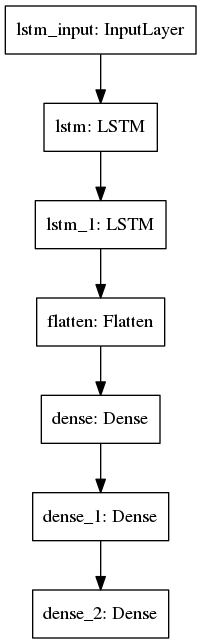

In [5]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 1), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128))
model.add(Dense(units = 40))
model.add(Dense(units = output_days))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

# Training the model with `Open` data

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_01'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x[:, :, :1]
train_label = train_y[:, :, :1]
test_input = test_x[:, :, :1]
test_label = test_y[:, :, :1]
train_label = np.squeeze(train_label, axis=-1)
test_label = np.squeeze(test_label, axis=-1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=10)

# train the model
train = model.fit(train_input, train_label, epochs=100, batch_size=100, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

W0911 09:07:27.219686 140248218236672 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 1248 samples, validate on 20 samples


W0911 09:07:27.408115 140248218236672 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
1248/1248 [==============================] - 5s 4ms/sample - loss: 0.1260 - val_loss: 0.2458
Epoch 2/100
1248/1248 [==============================] - 1s 486us/sample - loss: 0.0849 - val_loss: 0.1875
Epoch 3/100
1248/1248 [==============================] - 1s 485us/sample - loss: 0.0845 - val_loss: 0.1401
Epoch 4/100
1248/1248 [==============================] - 1s 469us/sample - loss: 0.0771 - val_loss: 0.1290
Epoch 5/100
1248/1248 [==============================] - 1s 485us/sample - loss: 0.0763 - val_loss: 0.1571
Epoch 6/100
1248/1248 [==============================] - 1s 510us/sample - loss: 0.0738 - val_loss: 0.1687
Epoch 7/100
1248/1248 [==============================] - 1s 525us/sample - loss: 0.0719 - val_loss: 0.1874
Epoch 8/100
1248/1248 [==============================] - 1s 518us/sample - loss: 0.0659 - val_loss: 0.1370
Epoch 9/100
1248/1248 [==============================] - 1s 520us/sample - loss: 0.0695 - val_loss: 0.1611
Epoch 10/100
1100/1248 [===============

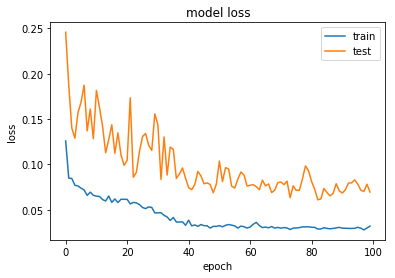

In [7]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:
count = len(test_input)
sc = MinMaxScaler()
output_prices = []

for i in range(count):
    test = test_data_append[i:i+input_days, :1]
    test = sc.getScalerData(test, offset=offset)
    output = model.predict(np.expand_dims(test, axis=0))
    output_prices.append(np.squeeze(sc.getInverseData(output), axis=0))
output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(20, 1) [[784.6848 ]
 [779.6811 ]
 [786.74097]
 [786.186  ]
 [792.91064]
 [803.98334]
 [804.04724]
 [800.4339 ]
 [799.6756 ]
 [798.8165 ]
 [798.3825 ]
 [800.2223 ]
 [799.3335 ]
 [803.16473]
 [806.81683]
 [823.0199 ]
 [831.73645]
 [838.7606 ]
 [831.1866 ]
 [812.179  ]]


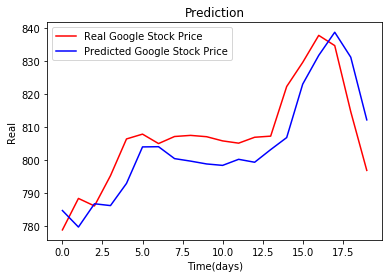

In [9]:
# Visualising the results
plt.plot(test_data_t[:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(output_prices[:, 0], color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()